# Investigating Fandango Movie Ratings

In this project, we're going to use our knowledge of statistics to see whether there's any bias on how Fandango rates their movies. On October 2015, a data journalist Walt Hickey discovered that Fandango rounds the actual ratings of the movies left by users up to the nearest half, for example 4.1 becomes 4.5. This was strong enough eveidence to suggest that fandangos rating system is biased and dishonest. We want to find out if Fandango still has some level of bias in their system now.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import re
import datetime as dt
from plotly import tools
from plotly import subplots

In [2]:
movie_ratings_16_17 = pd.read_csv('/Users/Tejas/csv_files/movie_ratings_16_17.txt')
fandango_comparison = pd.read_csv('/Users/Tejas/csv_files/fandango_scores.csv')

In [3]:
movie_ratings_16_17.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


In [4]:
fandango_comparison.columns

Index(['FILM', 'RottenTomatoes', 'RottenTomatoes_User', 'Metacritic',
       'Metacritic_User', 'IMDB', 'Fandango_Stars', 'Fandango_Ratingvalue',
       'RT_norm', 'RT_user_norm', 'Metacritic_norm', 'Metacritic_user_nom',
       'IMDB_norm', 'RT_norm_round', 'RT_user_norm_round',
       'Metacritic_norm_round', 'Metacritic_user_norm_round',
       'IMDB_norm_round', 'Metacritic_user_vote_count', 'IMDB_user_vote_count',
       'Fandango_votes', 'Fandango_Difference'],
      dtype='object')

In [5]:
fandango_comparison.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


After reading the README.md files of both the repositories to which these datasets belong to, I concluded that the two samples don't represent our population as there is no equal chance for all the movies to be selected. Only the movies with at least 30 fan reviews are present on Walt's Analysis and only the most popular movies with a significant number of votes were selected for the other dataset.

This tells us that the sampling process was not random.

Setbacks like this are common. Instead of starting over and scraping the research entirely, we can instead change the goal of our analysis by putting some limitations. Here's one idea of a goal we can work on: 
##### To see whether there is any change for the most popular movies on Fandango on the years 2015 and 2016.

The term "popular" is vague and we need to define it with precision before continuing. We'll use Hickey's benchmark of 30 fan ratings and consider a movie as "popular" only if it has 30 fan ratings or more on Fandango's website.

In [6]:
fandango_previous = fandango_comparison[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 
                                         'Fandango_Difference']]

fandango_after = movie_ratings_16_17[['movie', 'year', 'fandango']]

In [7]:
fandango_previous.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [8]:
fandango_after.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


In [9]:
fandango_previous['Year'] = fandango_previous['FILM'].str.extract(r'\((\d+)\)')

<ipython-input-9-36f063f7273d>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [10]:
fandango_previous.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,Year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


In [11]:
fandango_after.sample(10, random_state=1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


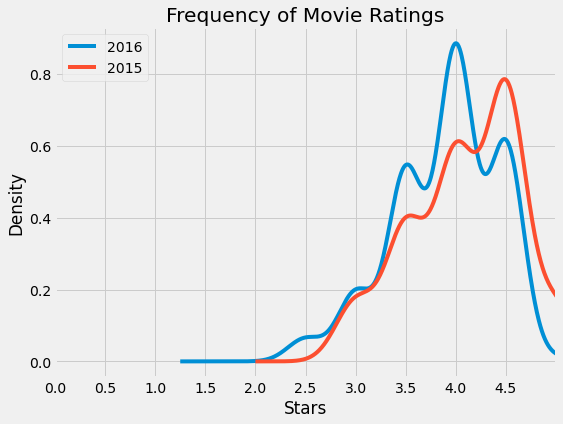

In [12]:
plt.style.use('fivethirtyeight')

fandango_after['fandango'].plot.kde(label='2016', legend=True)
fandango_previous['Fandango_Stars'].plot.kde(label='2015', legend=True, figsize=(8, 6))

plt.xlim(0, 5)
plt.xticks(np.arange(0, 5, 0.5))
plt.xlabel('Stars')
plt.title('Frequency of Movie Ratings')

plt.show()

Upon analysing the kernal density plots, we can see that:

* The shape of the distributions are left skewed.
* The movie ratings in 2015 have more number of higher ratings than those of 2016.
* We can see evidence on the graph that suggests that there is indeed a change between ratings for popular movies in 2015 and 2016.
* We can tell the direction of the difference between the ratings, ie: They also provided us with information about the direction of the difference: movies in 2016 were rated slightly lower than those in 2015.

> It's clear that there is a difference between the two distributions. The direction between the number of ratings is not clear. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change we saw on the kernel density plots.

In [13]:
print(fandango_previous['Fandango_Stars'].mean(), fandango_after['fandango'].mean(), sep='\n')

4.089041095890411
3.8948598130841123


In [14]:
print(fandango_previous['Fandango_Stars'].median(), fandango_after['fandango'].median(), sep='\n')

4.0
4.0


In [15]:
print(fandango_previous['Fandango_Stars'].mode(), fandango_after['fandango'].mode(), sep='\n')

0    4.5
dtype: float64
0    4.0
dtype: float64


* The average rating for movies in 2015 were greater than movies in 2016.
* Most of the movies were rated 4.5 stars in 2015 and 4 stars in 2016.

This tells us that the ratings of movies in 2015 were higher than those in 2016. There is just a slight difference between the two.

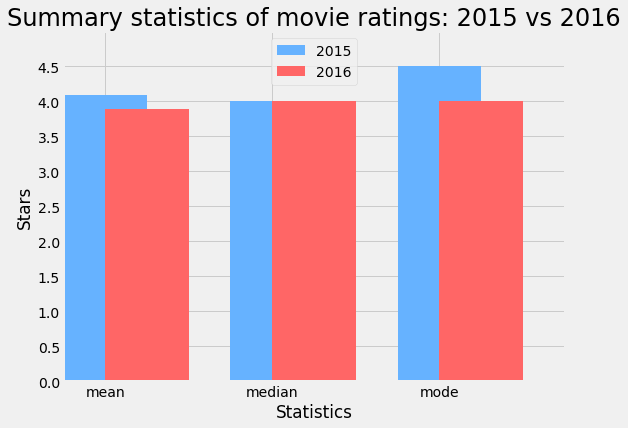

In [16]:
summary = pd.DataFrame()

summary['2015'] = [fandango_previous['Fandango_Stars'].mean(), 
                   fandango_previous['Fandango_Stars'].median(),
                  fandango_previous['Fandango_Stars'].mode()[0]]

summary['2016'] = [fandango_after['fandango'].mean(),
                  fandango_after['fandango'].median(),
                  fandango_after['fandango'].mode()[0]]

summary.index = ['mean', 'median', 'mode']

plt.style.use('fivethirtyeight')

summary['2015'].plot.bar(color='#66B2FF', label='2015', legend=True, align='center')
summary['2016'].plot.bar(color='#FF6666', label='2016', legend=True, align='edge', figsize=(8, 6), rot=0)

plt.title('Summary statistics of movie ratings: 2015 vs 2016', fontsize=24)
plt.ylim(0, 5)
plt.yticks(np.arange(0, 5, .5))
plt.xlabel('Statistics')
plt.ylabel('Stars')

plt.legend(loc='upper center')

plt.show()

From our grouped bar chart, we can see that there is indeed a difference between the ratings for movies released in 2015 and 2016.